notes on 2019.12.23:
1. statistics of radar data
2. pick rainny cases for testing
- Build datasets (2 images for OF, 12 images for AD). Select data that is  rainy region >10% for at least 2 hours.  One year is 365x24 = 8544 hours or 102 k images, prepare at least 10 k pair of samples to test.
- Compare 3 approaches, Du original, rainy motion, pysteps. Metrics is CSI and computation speed.  The goal is acheive CSI > 0.5 in 1 hour lead time forecast for a threshold of 1 mm/h

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

data_folder = "/Users/jiang/data/radar20190101"
grib_files = glob.glob(os.path.join(data_folder,"*.000"))  # 288 = 12*24
grib_files.sort()

/Users/jiang/github_all/rainymotion/docs/notebooks


### read wgrib2 file into nc file

In [22]:
if False:  # only do it once
    var = "surface"
    for grib_file in grib_files:
        ncfile = grib_file.split(".")[0]+".nc"
        cmd = f"wgrib2 {grib_file} -s | egrep '({var})'|wgrib2 -i {grib_file} -netcdf {ncfile}"
        fail = os.system(cmd)  # 0 indicate success, others indicate fail
        if fail:
            print("wgrib2 wrong at ",grib_file)

In [2]:
from netCDF4 import Dataset
nc_file = "/Users/jiang/data/radar20190101/20190101_000000.nc"
root = Dataset(nc_file, "r")

In [3]:
from datetime import datetime,timedelta
dt = datetime(1970, 1, 1) + timedelta(seconds = root['time'][0].compressed()[0])
date_string = dt.strftime('%Y-%m-%d %H:%M UTC ')
print(date_string)

2019-01-01 00:00 UTC 


### check rain coverage in Honshu

In [6]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [7]:
honshu_rain = []
threshold = 1 #  mm/h
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled().astype('float16')
    honshu_rain.append(np.sum(rain_filled >= threshold)/1e6)  # total pixels in one image is 1000*1000

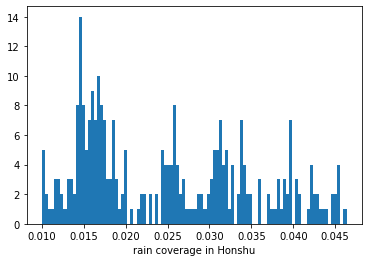

In [8]:
plt.hist(honshu_rain,100)
plt.xlabel("rain coverage in Honshu")
plt.show()

## test rainymotion sparse mode, dense mode and persistence

In [9]:
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
import wradlib.ipol as ipol
%matplotlib inline
from netCDF4 import Dataset

In [10]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [12]:
all_data = []
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled()
    all_data.append(rain_filled) 

In [78]:
%%time
#now = 100
for now in range(1,270,12):
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = 2019.1.1-{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])

    model = models.SparseSD()
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)

    sparse_12 = []
    for i in range (12):
        sparse_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    model = models.Dense()
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)
    dense_12 = []
    for i in range (12):
        dense_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    persist_12 = []
    for i in range (12):
        persist_12.append(metrics.CSI(all_data[now+1+i],all_data[now], threshold = 1))

    plt.figure(dpi = 100)
    plt.plot(list(range(5,65,5)), dense_12, '-*', label = "dense")
    plt.plot(list(range(5,65,5)), sparse_12, '-s',label = "sparse")
    plt.plot(list(range(5,65,5)), persist_12, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("threat score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2019.1.1-{hh}:{mm},rainymotion+opencv,threshold = 1 mm/h")
    plt.grid()
    #plt.show()
    plt.savefig("JMA_rainymotion" + str(now).zfill(3) + ".png",format = "png")
    plt.close()

now = 2019.1.1-00:05
now = 2019.1.1-01:05
now = 2019.1.1-02:05
now = 2019.1.1-03:05
now = 2019.1.1-04:05
now = 2019.1.1-05:05
now = 2019.1.1-06:05
now = 2019.1.1-07:05
now = 2019.1.1-08:05
now = 2019.1.1-09:05
now = 2019.1.1-10:05
now = 2019.1.1-11:05
now = 2019.1.1-12:05
now = 2019.1.1-13:05
now = 2019.1.1-14:05
now = 2019.1.1-15:05
now = 2019.1.1-16:05
now = 2019.1.1-17:05
now = 2019.1.1-18:05
now = 2019.1.1-19:05
now = 2019.1.1-20:05
now = 2019.1.1-21:05
now = 2019.1.1-22:05
CPU times: user 12min 20s, sys: 12.8 s, total: 12min 33s
Wall time: 2min 22s


In [42]:
import imageio
png_files = glob.glob("./JMA_rainymotion*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = 'JMA_rainymotion-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

23


##  visualize the differece in gif

In [61]:
from rainymotion import utils
data_scaled, c1, c2 = utils.RYScaler(np.array(all_data))
nowcast_scaled, c3,c4 = utils.RYScaler(np.array(nowcast))

In [93]:
for i in range(12):
    plt.figure(dpi = 250)
    image1 = data_scaled[now+1+i]
    image2 = nowcast_scaled[i]
    plt.imshow(image1,cmap = 'gray_r')
    plt.imshow(image2,cmap = 'gray_r',alpha = 0.5)
    plt.title(f"now = 2019.1.1-{hh}:{mm},+{str(i*5+5).zfill(2)}min,Truth(black),forecast(shadow)")
    plt.grid()
    plt.savefig("JMA_rainymotion_check" + str(i).zfill(2) + ".png",format = "png")
    plt.close()

In [94]:
import imageio
png_files = glob.glob("./JMA_rainymotion_check*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = 'JMA_rainymotion_check-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

12


## check data distribution

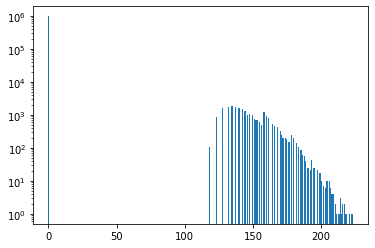

In [60]:
plt.hist(data_scaled[now+1+i].ravel(),256)
plt.yscale('log')